# Shopping Recommendation System

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

df_original = pd.read_excel('market/Online Retail.xlsx')

## RFM

In [2]:
df = df_original.copy(deep=True)

df['Revenue'] = df_original['Quantity'] * df_original['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df_original['InvoiceDate'])
# Filter out negative quantities
df = df[df['Quantity'] > 0]

# Filter out invoices with C in the beginning because they are cancellations
# df = df[df['InvoiceNo'].str.startswith('C') == False]

In [3]:
CURRENT_TIMESTAMP = df['InvoiceDate'].max() + dt.timedelta(days=1)

TIMEFRAME = 90 # days

df_filtered = df[df['InvoiceDate'] >= CURRENT_TIMESTAMP - dt.timedelta(days=TIMEFRAME)]

# rfm table
rfm_table = df_filtered.groupby('CustomerID').agg({
  'InvoiceDate': lambda x: (CURRENT_TIMESTAMP - x.max()).days,
  'InvoiceNo': 'nunique',
  'Revenue': lambda x: x.sum() * 30000
})

# Convert values
# recency = 5 if the customer made a purchase in the last 30 days, 4 if in the last 60 days, 3 if in the last 90 days, 2 if in the last 180 days, 1 if over 180 days
# frequency = 5 if the customer made more than 20 purchases, 4 if more than 10, 3 if more than 5, 2 if more than 2, 1 if less than 2
# monetary = 5 if the customer spent more than 20M, 4 if more than 10M, 3 if more than 5M, 2 if more than 2M, 1 if less than 2M
rfm_table['Recency'] = pd.cut(rfm_table['InvoiceDate'], bins=[0, 30, 60, 90, 180, 2000], labels=[5, 4, 3, 2, 1])
rfm_table['Frequency'] = pd.cut(rfm_table['InvoiceNo'], bins=[0, 2, 5, 10, 20, 2000], labels=[1, 2, 3, 4, 5])
rfm_table['Monetary'] = pd.cut(rfm_table['Revenue'], bins=[0, 2000000, 5000000, 10000000, 20000000, 1000000000], labels=[1, 2, 3, 4, 5])

# remove the original columns
rfm_table = rfm_table.drop(columns=['InvoiceDate', 'InvoiceNo', 'Revenue'])

# monetary not NaN
rfm_table = rfm_table[rfm_table['Monetary'].notna()]

In [4]:
# Save to CSV
rfm_table.to_csv('./input/rfm_table.csv')

## Analyze

In [11]:
# Load from CSV
rfm_table = pd.read_csv('./input/rfm_table.csv', index_col='CustomerID')

rfm_table

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,5,1,5
12348.0,3,1,3
12349.0,5,1,5
12352.0,4,2,5
12356.0,5,1,1
...,...,...,...
18277.0,4,1,2
18278.0,3,1,3
18282.0,5,1,2


In [12]:
def classify_customer(row):
  fm_score = (row['Frequency'] + row['Monetary']) // 2
  r_score = int(row['Recency'])
  labelling_grid = [
    ['Lost', 'Lost', 'About to Sleep', 'Promising', 'Price Sensitive'],
    ['Lost', 'Lost', 'About to Sleep', 'Recent Users', 'Recent Users'],
    ['Hibernating', 'Hibernating', 'Need Attention', 'Potential Loyalists', 'Potential Loyalists'],
    ['Hibernating', 'Hibernating', 'Loyal Customer', 'Loyal Customer', 'Champions'],
    ["Can't Lose Them", "Can't Lose Them", 'Loyal Customer', 'Loyal Customer', 'Champions']
  ]
  return labelling_grid[fm_score - 1][r_score - 1]

rfm_table['CustomerType'] = rfm_table.apply(classify_customer, axis=1)

rfm_table

,Recency,Frequency,Monetary,CustomerType
CustomerID,,,,
12347.0,5,1,5,Potential Loyalists
12348.0,3,1,3,About to Sleep
12349.0,5,1,5,Potential Loyalists
12352.0,4,2,5,Potential Loyalists
12356.0,5,1,1,Price Sensitive
...,...,...,...,...
18277.0,4,1,2,Promising
18278.0,3,1,3,About to Sleep
18282.0,5,1,2,Price Sensitive


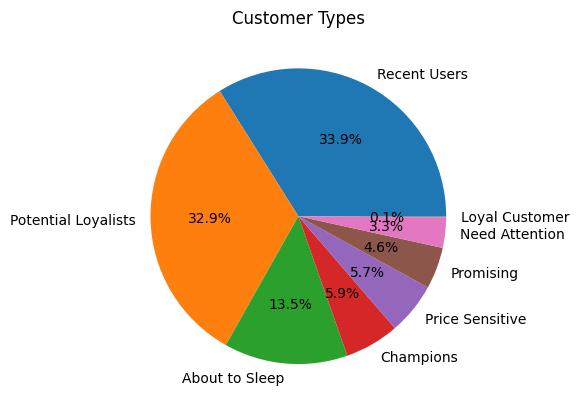

In [13]:
customer_type_counts = rfm_table['CustomerType'].value_counts()
customer_type_counts.plot.pie(autopct='%1.1f%%')
plt.title('Customer Types')
# remove the 'count' label
plt.ylabel('')
plt.savefig('./output/rfm_customer_types.png')

# Market Basket

In [ ]:
df = df_original.copy(deep=True)

product_count = df['Description'].value_counts().head(10)
product_count.plot.bar()